## EasyOCR

In [ ]:
%pip install easyocr

In [ ]:
import easyocr
import cv2
import matplotlib.pyplot as plt

In [ ]:
reader = easyocr.Reader(['en']) 

In [ ]:
image_path = '/Users/user/Desktop/Снимок экрана 2024-07-06 в 21.46.18.png'  # Замените на путь к вашему изображению
image = cv2.imread(image_path)
#image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Отображение исходного изображения
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

In [ ]:
results = reader.readtext(image_path, detail=1,allowlist='1234567890ABEKMHOPCTYX')

In [ ]:
for (bbox, text, prob) in results:
    text=text[:8]
    print(f"Обнаруженный текст: {text}, Вероятность: {prob}")
    print(f"Координаты границ текста: {bbox}")

# Визуализация результатов
for (bbox, text, prob) in results:
    # Координаты границ
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))

    # Рисуем рамку вокруг текста
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Отображение изображения с распознанным текстом
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Изображение с распознанным текстом')
plt.axis('off')
plt.show()


In [ ]:
from PIL import Image, ImageDraw
import os

# Размеры шаблона
template_width = 512
template_height = 112
background_color = 'white'

# Путь к папке с изображениями символов
symbols_folder = "/Users/user/virtualenv/hacks/digitalproriv_grozny/numbers"

# Номер для размещения
number = "A977CO798"

# Создание шаблона
template = Image.new('RGB', (template_width, template_height), background_color)
draw = ImageDraw.Draw(template)

# Загрузка и размещение символов
def place_symbol(image_path, position):
    symbol_image = Image.open(image_path)
    symbol_image = symbol_image.resize((int(position['width']), int(position['height'])))
    template.paste(symbol_image, (int(position['x']), int(position['y'])))

# Определение позиций символов на шаблоне
symbol_positions = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

# Размещение каждого символа на шаблоне
for symbol_index, char in enumerate(number):
    for pos_info in symbol_positions:
        if pos_info['pos'] == symbol_index + 1:  # pos starts from 1, symbol_index starts from 0
            p1_x, p1_y = pos_info['p1'][0] * template_width, pos_info['p1'][1] * template_height
            p2_x, p2_y = pos_info['p2'][0] * template_width, pos_info['p2'][1] * template_height
            symbol_width = p2_x - p1_x
            symbol_height = p2_y - p1_y
            
            # Загрузка и масштабирование изображения символа
            image_path = os.path.join(symbols_folder, f"{char}.png")
            symbol_image = Image.open(image_path)
            symbol_image = symbol_image.resize((int(symbol_width), int(symbol_height)))
            
            # Размещение символа на шаблоне
            template.paste(symbol_image, (int(p1_x), int(p1_y)))

# Сохранение изображения
output_path = f'russian_license_plate_custom_{number}.png'
template.save(output_path)

# Отображение изображения
plt.imshow(template)
plt.axis('off')
plt.title("Регистрационный номер РФ: A001AA170")
plt.show()


print(f"Изображение сохранено по пути: {output_path}")


yolo_easyocr

In [ ]:
import cv2
import matplotlib.pyplot as plt
import easyocr
import cv2
import matplotlib.pyplot as plt
import json
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
import numpy as np
import os

In [ ]:
image_path = "/Users/user/virtualenv/hacks/plate_deformation/0a6aa844e3834971.jpg"
annotation_path = "/Users/user/virtualenv/hacks/plate_deformation/0a6aa844e3834971.txt"

# Чтение изображения
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Чтение разметки
with open(annotation_path, 'r') as file:
    lines = file.readlines()

# Преобразование разметки
annotations = []
for line in lines:
    data = line.strip().split()
    class_id = int(data[0])
    x_center, y_center, width, height = map(float, data[1:])
    annotations.append((class_id, x_center, y_center, width, height))

image_height, image_width, _ = image.shape

In [ ]:
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    return x_min, y_min, x_max, y_max

# Отрисовка bounding boxes на изображении
image_with_boxes = image.copy()
for ann in annotations:
    class_id, x_center, y_center, width, height = ann
    x_min, y_min, x_max, y_max = yolo_to_bbox(x_center, y_center, width, height, image_width, image_height)
    cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

# Отображение изображения с bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Изображение с ограничивающими рамками")
plt.show()

# Отображение каждого bounding box отдельно
for idx, ann in enumerate(annotations):
    class_id, x_center, y_center, width, height = ann
    x_min, y_min, x_max, y_max = yolo_to_bbox(x_center, y_center, width, height, image_width, image_height)
    bbox_image = image[y_min:y_max, x_min:x_max]
    plt.figure(figsize=(5, 5))
    plt.imshow(bbox_image)
    plt.axis('off')
    plt.title(f"Bounding Box {idx+1} - Класс {class_id}")
    plt.show()

In [ ]:
# Пути к файлам
image_path = "/Users/user/virtualenv/hacks/plate_deformation/0a6aa844e3834971.jpg"
annotation_path = "/Users/user/virtualenv/hacks/plate_deformation/0a6aa844e3834971.txt"

# Создание объекта Reader
reader = easyocr.Reader(['en'])

# Чтение изображения
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Чтение разметки
with open(annotation_path, 'r') as file:
    lines = file.readlines()

# Преобразование разметки
annotations = []
for line in lines:
    data = line.strip().split()
    class_id = int(data[0])
    x_center, y_center, width, height = map(float, data[1:])
    annotations.append((class_id, x_center, y_center, width, height))
    print(annotations)

image_height, image_width, _ = image.shape

# Функция для преобразования координат
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    return x_min, y_min, x_max, y_max

# Преобразование bounding box'ов и сортировка по x_min
bounding_boxes = []
for ann in annotations:
    class_id, x_center, y_center, width, height = ann
    x_min, y_min, x_max, y_max = yolo_to_bbox(x_center, y_center, width, height, image_width, image_height)
    bounding_boxes.append((x_min, y_min, x_max, y_max, class_id))

# Сортировка bounding box'ов по x_min (по возрастанию)
bounding_boxes.sort(key=lambda bbox: bbox[0])

# Извлечение и обработка кропов
recognized_texts = []
cropped_images = []

In [ ]:
target_size = (89, 154) 

In [ ]:
for idx, (x_min, y_min, x_max, y_max, class_id) in enumerate(bounding_boxes):
    # Извлечение кропа
    bbox_image = image[y_min:y_max, x_min:x_max]
    cropped_images.append(bbox_image)

    # Изменение размера кропа до заданного
    resized_crop = cv2.resize(bbox_image, target_size, interpolation=cv2.INTER_AREA)

    # Преобразование кропа в формат, совместимый с EasyOCR
    crop_image_rgb = cv2.cvtColor(resized_crop, cv2.COLOR_RGB2BGR)

    # Установка allowlist в зависимости от индекса
    if idx in [0, 4, 5]:  # Индексы 0, 4 и 5 (первый, пятый и шестой кроп)
        allowlist = 'ABEKMHOPCTYX'
        default_value = 'O'
    else:  # Остальные кропы
        allowlist = '1234567890'
        default_value = '7'

    # Распознавание текста с EasyOCR с использованием соответствующего allowlist
    results = reader.readtext(crop_image_rgb, detail=0, allowlist=allowlist)
    
    # Проверка на наличие результатов и добавление предопределенных значений, если распознанный текст пуст
    if results:
        recognized_text = results[0]
    else:
        recognized_text = default_value

    recognized_texts.append(recognized_text)
    print(f"Обнаруженный текст: {recognized_text}")

# Объединение текста
final_text = ''.join(recognized_texts)
print(f"Итоговая строка: {final_text}")

# Визуализация кропов и их изменения размеров
for idx, (crop_image, crop_text) in enumerate(zip(cropped_images, recognized_texts)):
    # Визуализация оригинального кропа
    plt.figure(figsize=(5, 5))
    plt.imshow(crop_image)
    plt.axis('off')
    plt.title(f"Оригинальный Кроп {idx+1}")
    plt.show()

In [ ]:
template_width = 512
template_height = 112
background_color = 'white'

symbols_folder = "/Users/user/virtualenv/hacks/digitalproriv_grozny/numbers"

template = Image.new('RGB', (template_width, template_height), background_color)
draw = ImageDraw.Draw(template)

def place_symbol(image_path, position):
    symbol_image = Image.open(image_path)
    symbol_image = symbol_image.resize((int(position['width']), int(position['height'])))
    template.paste(symbol_image, (int(position['x']), int(position['y'])))

# Определение позиций символов на шаблоне
symbol_positions = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

# Размещение каждого символа на шаблоне
for symbol_index, char in enumerate(final_text):
    for pos_info in symbol_positions:
        if pos_info['pos'] == symbol_index + 1:
            p1_x, p1_y = pos_info['p1'][0] * template_width, pos_info['p1'][1] * template_height
            p2_x, p2_y = pos_info['p2'][0] * template_width, pos_info['p2'][1] * template_height
            symbol_width = p2_x - p1_x
            symbol_height = p2_y - p1_y

            image_path = os.path.join(symbols_folder, f"{char}.png")
            symbol_image = Image.open(image_path)
            symbol_image = symbol_image.resize((int(symbol_width), int(symbol_height)))
            
            # Размещение символа на шаблоне
            template.paste(symbol_image, (int(p1_x), int(p1_y)))

# Сохранение изображения
output_path = f'russian_license_plate_custom_{final_text}.png'
template.save(output_path)

# Отображение изображения
plt.imshow(template)
plt.axis('off')
plt.title(f'Регистрационный номер РФ: {final_text}')
plt.show()
print(f"Изображение сохранено по пути: {output_path}")


## final version to docker

In [3]:
import cv2
import matplotlib.pyplot as plt
import easyocr
from PIL import Image, ImageDraw
import numpy as np
import os
from ultralytics import YOLO


0: 192x320 9 symbols, 32.2ms
Speed: 3.6ms preprocess, 32.2ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)


/var/folders/j3/htl_67j53z9dlhmz3d7mcs7c0000gn/T/ipykernel_7429/161635153.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(pred.cls)  # Идентификатор класса


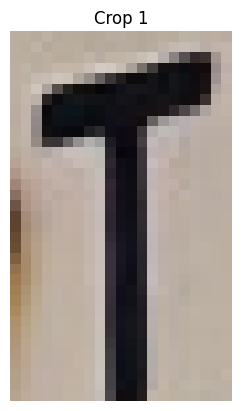

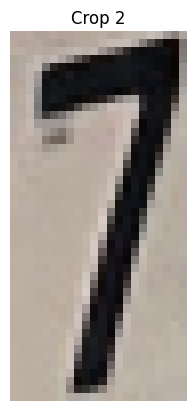

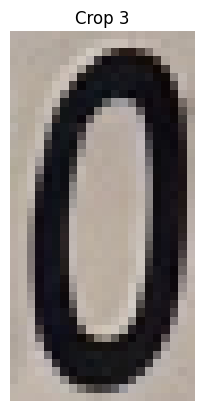

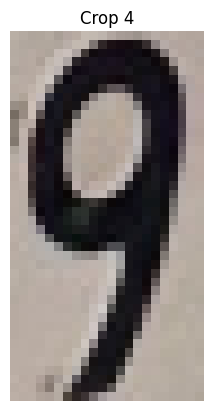

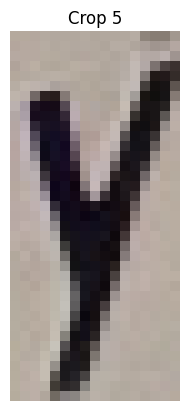

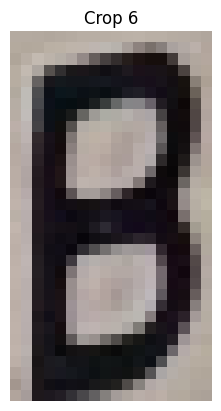

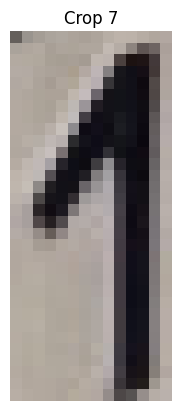

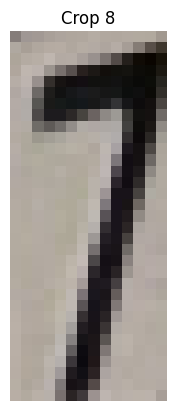

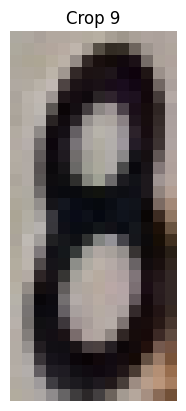

In [26]:
def extract_and_process_crops(image):
    """
    Функция для извлечения и обработки кропов с использованием предобученной модели YOLO.
    
    Args:
        image_path (str): Путь к изображению.

    Returns:
        list: Список изображений (кропов), извлеченных с использованием модели YOLO.
    """
    if image is None:
        print(f"Ошибка чтения изображения {image_path}")
        return []

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image_rgb.shape
    model_weights = '/Users/user/Downloads/Telegram Desktop/best (3).pt'
    model = YOLO(model_weights, task='detect')
    results = model.predict(image_rgb, device='cpu', conf=0.30, iou=0.45)

    preds = results[0].boxes.cpu().numpy()

    # Преобразование bounding box'ов и сортировка по x_min
    bounding_boxes = []
    for pred in preds:
        bbox = pred.xyxy[0]  # Извлечение координат bounding box'а
        class_id = int(pred.cls)  # Идентификатор класса
        x_min, y_min, x_max, y_max = map(int, bbox)
        bounding_boxes.append((x_min, y_min, x_max, y_max, class_id))

    # Сортировка bounding box'ов по x_min (по возрастанию)
    bounding_boxes.sort(key=lambda bbox: bbox[0])

    cropped_images = []
    for idx, (x_min, y_min, x_max, y_max, class_id) in enumerate(bounding_boxes):
        # Извлечение кропа
        bbox_image = image_rgb[y_min:y_max, x_min:x_max]
        cropped_images.append(bbox_image)

    return cropped_images

image_path = '/Users/user/Downloads/51_anno/obj_train_data/images/train/0b90c1c74d46abf7.jpg'
image = cv2.imread(image_path)
cropped_images = extract_and_process_crops(image)

for idx, crop in enumerate(cropped_images):
    plt.figure()
    plt.imshow(crop)
    plt.title(f'Crop {idx+1}')
    plt.axis('off')
    plt.show()


In [25]:
# def extract_and_process_crops_anno(image_path, annotation_path):
#     # Чтение изображения
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Чтение разметки
#     with open(annotation_path, 'r') as file:
#         lines = file.readlines()

#     # Преобразование разметки
#     annotations = []
#     for line in lines:
#         data = line.strip().split()
#         class_id = int(data[0])
#         x_center, y_center, width, height = map(float, data[1:])
#         annotations.append((class_id, x_center, y_center, width, height))

#     image_height, image_width, _ = image.shape

#     # Преобразование bounding box'ов и сортировка по x_min
#     bounding_boxes = []
#     for ann in annotations:
#         class_id, x_center, y_center, width, height = ann
#         x_min, y_min, x_max, y_max = yolo_to_bbox(x_center, y_center, width, height, image_width, image_height)
#         bounding_boxes.append((x_min, y_min, x_max, y_max, class_id))

#     # Сортировка bounding box'ов по x_min (по возрастанию)
#     bounding_boxes.sort(key=lambda bbox: bbox[0])

#     # Извлечение и обработка кропов
#     cropped_images = []
#     for idx, (x_min, y_min, x_max, y_max, class_id) in enumerate(bounding_boxes):
#         # Извлечение кропа
#         bbox_image = image[y_min:y_max, x_min:x_max]
#         cropped_images.append(bbox_image)

#     return cropped_images


In [27]:
def detect_symbols(cropped_images, target_size=(89, 154)):
    # Создание объекта Reader
    reader = easyocr.Reader(['en'])

    recognized_texts = []
    for idx, crop_image in enumerate(cropped_images):
        # Изменение размера кропа до заданного
        resized_crop = cv2.resize(crop_image, target_size, interpolation=cv2.INTER_AREA)

        # Преобразование кропа в формат, совместимый с EasyOCR
        crop_image_rgb = cv2.cvtColor(resized_crop, cv2.COLOR_RGB2BGR)

        # Установка allowlist в зависимости от индекса
        if idx in [0, 4, 5]:  # Индексы 0, 4 и 5 (первый, пятый и шестой кроп)
            allowlist = 'ABEKMHOPCTYX'
            default_value = 'C'
        else:  # Остальные кропы
            allowlist = '1234567890'
            default_value = '7'

        results = reader.readtext(crop_image_rgb, detail=0, allowlist=allowlist)
        
        if results:
            recognized_text = results[0]
        else:
            recognized_text = default_value

        recognized_texts.append(recognized_text)
        print(f"Обнаруженный текст: {recognized_text}")

    # Объединение текста
    final_text = ''.join(recognized_texts)
    print(f"Итоговая строка: {final_text}")

    return final_text


In [32]:
def postprocess_symbols(final_text):
    template_width = 512
    template_height = 112
    background_color = 'white'

    symbols_folder = "/Users/user/virtualenv/hacks/digitalproriv_grozny/numbers"

    template = Image.new('RGB', (template_width, template_height), background_color)
    draw = ImageDraw.Draw(template)

    def place_symbol(image_path, position):
        symbol_image = Image.open(image_path)
        symbol_image = symbol_image.resize((int(position['width']), int(position['height'])))
        template.paste(symbol_image, (int(position['x']), int(position['y'])))
        
    # Определение позиций символов на шаблоне
    symbol_positions = [
        {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
        {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
        {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
        {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
        {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
        {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
        {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
        {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
        {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
    ]

    two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

    # Размещение каждого символа на шаблоне
    for symbol_index, char in enumerate(final_text):
        if len(final_text)>8:
            for pos_info in symbol_positions:
                if pos_info['pos'] == symbol_index + 1:
                    p1_x, p1_y = pos_info['p1'][0] * template_width, pos_info['p1'][1] * template_height
                    p2_x, p2_y = pos_info['p2'][0] * template_width, pos_info['p2'][1] * template_height
                    symbol_width = p2_x - p1_x
                    symbol_height = p2_y - p1_y
    
                    image_path = os.path.join(symbols_folder, f"{char}.png")
                    symbol_image = Image.open(image_path)
                    symbol_image = symbol_image.resize((int(symbol_width), int(symbol_height)))
                    
                    # Размещение символа на шаблоне
                    template.paste(symbol_image, (int(p1_x), int(p1_y)))
        elif len(final_text)==8:
            symbol_positions=two_digit_region_template
            for pos_info in symbol_positions:
                if pos_info['pos'] == symbol_index + 1:
                    p1_x, p1_y = pos_info['p1'][0] * template_width, pos_info['p1'][1] * template_height
                    p2_x, p2_y = pos_info['p2'][0] * template_width, pos_info['p2'][1] * template_height
                    symbol_width = p2_x - p1_x
                    symbol_height = p2_y - p1_y
    
                    image_path = os.path.join(symbols_folder, f"{char}.png")
                    symbol_image = Image.open(image_path)
                    symbol_image = symbol_image.resize((int(symbol_width), int(symbol_height)))
                    
                    # Размещение символа на шаблоне
                    template.paste(symbol_image, (int(p1_x), int(p1_y)))
    return template
    # # Сохранение изображения
    # output_path = f'russian_license_plate_custom_{final_text}.png'
    # template.save(output_path)

    # # Отображение изображения
    # plt.imshow(template)
    # plt.axis('off')
    # plt.title(f'Регистрационный номер РФ: {final_text}')
    # plt.show()
    # print(f"Изображение сохранено по пути: {output_path}")


#postprocess_symbols(final_text)


0: 192x320 9 symbols, 25.8ms
Speed: 1.0ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


/var/folders/j3/htl_67j53z9dlhmz3d7mcs7c0000gn/T/ipykernel_7429/161635153.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(pred.cls)  # Идентификатор класса
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Обнаруженный текст: T
Обнаруженный текст: 7
Обнаруженный текст: 0
Обнаруженный текст: 9
Обнаруженный текст: C
Обнаруженный текст: B
Обнаруженный текст: 1
Обнаруженный текст: 7
Обнаруженный текст: 8
Итоговая строка: T709CB178


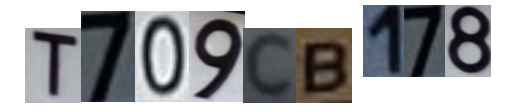

In [33]:
image_path = "/Users/user/Downloads/51_anno/obj_train_data/images/train/0b90c1c74d46abf7.jpg"
mage = cv2.imread(image_path)
cropped_images = extract_and_process_crops(image)

final_text = detect_symbols(cropped_images)
postprocess_symbols(final_text)

In [11]:
%pip list 

Package                      Version              Editable project location
---------------------------- -------------------- ----------------------------------------------
absl-py                      2.1.0
affine                       2.4.0
aiofiles                     23.2.1
aiohttp                      3.9.5
aiosignal                    1.3.1
altair                       5.3.0
anyio                        4.3.0
appnope                      0.1.4
argcomplete                  3.2.3
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.3
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bitarray                     2.9.2
bitstring                    4.2.3
bleach                       6.1.0
blinker                      1.8.2
boto3           

## train yolov8n

In [ ]:
import os

# Путь к папке с изображениями и разметкой
image_folder = '/Users/user/Downloads/51_anno/obj_train_data/images'

# Получаем все файлы в папке
files = os.listdir(image_folder)

for file in files:
    if file.endswith('.txt'):
        txt_path = os.path.join(image_folder, file)
        with open(txt_path, 'r') as f:
            lines = f.readlines()

        # Проверяем, пустой ли файл
        if len(lines) == 0:
            # Если файл пустой, удаляем его и соответствующее изображение
            image_name = file.replace('.txt', '.jpg')
            image_path = os.path.join(image_folder, image_name)
            
            if os.path.exists(image_path):
                os.remove(image_path)
                print(f"Удалено изображение: {image_path}")
            os.remove(txt_path)
            print(f"Удален файл разметки: {txt_path}")

print("Удаление негативных семплов завершено.")


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Папка с изображениями и файлами разметки
image_folder = '/Users/user/Downloads/51_anno/obj_train_data/images'

# Создаем папки для тренировки и валидации
train_image_folder = '/Users/user/Downloads/51_anno/obj_train_data/images/train'
val_image_folder = '/Users/user/Downloads/51_anno/obj_train_data/images/val'
train_label_folder = '/Users/user/Downloads/51_anno/obj_train_data/labels/train'
val_label_folder = '/Users/user/Downloads/51_anno/obj_train_data/labels/val'

os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(train_label_folder, exist_ok=True)
os.makedirs(val_label_folder, exist_ok=True)

# Получаем список всех файлов изображений и соответствующих файлов разметки
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
label_files = [f.replace('.jpg', '.txt') for f in image_files]

# Разделение данных на тренировочную и валидационную выборки
train_images, val_images, train_labels, val_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

# Функция для копирования файлов
def copy_files(files, source_folder, target_folder):
    for file in files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(target_folder, file))

# Копируем файлы
copy_files(train_images, image_folder, train_image_folder)
copy_files(val_images, image_folder, val_image_folder)
copy_files(train_labels, image_folder, train_label_folder)
copy_files(val_labels, image_folder, val_label_folder)

print("Данные разделены на тренировочную и валидационную выборки.")


In [ ]:
from ultralytics import YOLO

# Загрузка предварительно обученной модели YOLOv8n
model = YOLO('/Users/user/virtualenv/hacks/plate_deformation/yolov8n.pt')

# Запуск обучения
results = model.train(
    data='/Users/user/virtualenv/hacks/data.yaml',  # Путь к файлу конфигурации данных
    epochs=50,  # Количество эпох (можете изменить по необходимости)
    batch=16,  # Размер батча (можете изменить по необходимости)
    imgsz=640  # Размер изображений (можете изменить по необходимости)
)

# Вы можете сохранить модель после обучения
model.save('/Users/user/Downloads/51_anno/obj_train_data/yolov8n_trained.pt')


In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
import random
import numpy as np

# Загрузка обученной модели
model_weights = '/Users/user/Downloads/Telegram Desktop/best (3).pt'
model = YOLO(model_weights, task='detect')

# Путь к папке с изображениями
images_dir = '/Users/user/Downloads/51_anno/obj_train_data/images/train'

# Получение списка файлов изображений
filenames = sorted(glob(os.path.join(images_dir, '*.jpg')))
ix = random.randint(0, len(filenames) - 1)
filename = filenames[ix]

print(f"Index: {ix}, Filename: {filename}")

# Чтение изображения
image = cv2.imread(filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Выполнение предсказания
results = model.predict(image_rgb, device='cpu', conf=0.30, iou=0.45)

# Извлечение предсказанных боксов
preds = results[0].boxes.cpu().numpy()

# Визуализация всех кропов на исходной картинке
if len(preds) > 0:
    for pred in preds:
        bbox = pred.xyxy[0]
        class_id = int(pred.cls[0])  # Извлекаем первый элемент массива
        confidence = pred.conf[0]  # Извлекаем первый элемент массива
        
        x_min, y_min, x_max, y_max = map(int, bbox)
        
        # Рисование прямоугольника на исходной картинке
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        label = f'{class_id} {confidence:.2f}'
        cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Показ исходного изображения с прямоугольниками
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title('Original Image with Bounding Boxes')
    plt.axis('off')
    plt.show()
    
    # Показ каждого кропа
    for i, pred in enumerate(preds):
        bbox = pred.xyxy[0]
        x_min, y_min, x_max, y_max = map(int, bbox)
        
        # Извлечение кропа
        crop = image_rgb[y_min:y_max, x_min:x_max]
        
        # Показ кропа
        plt.figure()
        plt.imshow(crop)
        plt.title(f'Crop {i+1}')
        plt.axis('off')
        plt.show()
else:
    print("No predictions found.")

# Показ предсказанного изображения
res_plotted = results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(res_plotted[:, :, ::-1])
plt.title('Predicted Image with Bounding Boxes')
plt.axis('off')
plt.show()